# TFRecord files and Protobuf for TF

## Importing libraries

In [81]:
import tensorflow as tf
from tensorflow.train import BytesList, FloatList, Int64List, FeatureList, FeatureLists
from tensorflow.train import Feature, Features, Example, SequenceExample
from sklearn.datasets import load_sample_images
import matplotlib.pyplot as plt
import seaborn as sns

## `TFRecord` binary format

In [2]:
with tf.io.TFRecordWriter('sample_data.tfrecord') as f: # writing to a TFRecord file
    f.write(b'First record')
    f.write(b'And second record')

In [3]:
filepaths = ['sample_data.tfrecord']
dataset = tf.data.TFRecordDataset(filepaths)

In [4]:
for item in dataset:
    print(item)

tf.Tensor(b'First record', shape=(), dtype=string)
tf.Tensor(b'And second record', shape=(), dtype=string)


- We can read mutiple TFRecord files using `TFRecordDataset`. By default it will read mutiple files one after another but we can set `num_parallel_read` for reading from mutiple records parallelly and interleaving them.

In [5]:
filepaths = ['sample_{}.tfrecord'.format(i) for i in range(5)] # Creating sample filepaths

In [6]:
for i, j in enumerate(filepaths):
    print(i, j)

0 sample_0.tfrecord
1 sample_1.tfrecord
2 sample_2.tfrecord
3 sample_3.tfrecord
4 sample_4.tfrecord


In [7]:
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write('File {} record {}'.format(i, j).encode('utf-8')) # 

In [8]:
dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads = 3)

In [9]:
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


### Compressed TFRecord files

In [10]:
options = tf.io.TFRecordOptions(compression_type = 'GZIP') # Setting the compression type

In [11]:
with tf.io.TFRecordWriter('Compressed_sample.tfrecord', options) as f: # Writing in the TFRecord file
    f.write(b'First record')
    f.write(b'Second record')

In [12]:
dataset = tf.data.TFRecordDataset(['Compressed_sample.tfrecord'], compression_type = 'GZIP') # Loading the TFRecord file

In [13]:
for item in dataset:
    print(item)

tf.Tensor(b'First record', shape=(), dtype=string)
tf.Tensor(b'Second record', shape=(), dtype=string)


## Protocol Buffers

- Writing a simple protobuf definition

In [14]:
%%writefile person.proto
syntax = 'proto3';
message Person{string name = 1; int32 id = 2; repeated string email = 3;}

Overwriting person.proto


- This definition says that we are using version 3 of the protobuff format and it specifies that each Person object may optionally have a name of type string, id of type int32 ande zero or more email fields each of type string.
- The numbers 1, 2 and 3 are field identifiers. They will be used in each record's binary representation.
- Once we have a defintion in the .proto file, we can compile it. This requires protoc, the protobuf compiler to generate access classes in Python(or some other language).

In [15]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports # Compiling the .proto file and generating python access class.

In [16]:
!ls person*

person.desc  person.proto  person_pb2.py


In [17]:
from person_pb2 import Person # Import the generated access class
person = Person(name = 'A1', id = 123, email = ['a@b.com']) # Creating a Person instance

In [18]:
print(person)

name: "A1"
id: 123
email: "a@b.com"



In [19]:
person.name # Read a field

'A1'

In [20]:
person.name = 'Alice'

In [21]:
person.email[0] # Repeated fields can be accessed like arrays

'a@b.com'

In [22]:
person.email.append('c@d.com') # Add a new email

In [23]:
person.email

['a@b.com', 'c@d.com']

In [24]:
s = person.SerializeToString() # Serializing to byte string

In [25]:
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

- This byte string is the binary data that is ready to be saved or transmitted over the network. When reading or recieving this binary data, we can parse it using the ParseFromString() method and we get a copy of the object that was serialized.

In [26]:
person2 = Person()

In [27]:
person2.ParseFromString(s) # Parsing the fields from the serialized byte string.

27

In [28]:
person == person2

True

In [29]:
person2

name: "Alice"
id: 123
email: "a@b.com"
email: "c@d.com"

- We could save the serialized Person object to a TFRecord file. then we could load and parse it. However `SerializeToString()` or `ParseFromString()` are not TF operations so they cant be included in a TF function except wrapping it using `tf.py_function()` operation which would make the code slower and less portable.
- For this TF does include special protobuf definitions for which it provides parsing operations.

## Custom protobufs

- In rare cases we may want to decode some custom protobuf like the one we created above. We have to use `tf.io.decode_proto()` function.

In [30]:
person_tf = tf.io.decode_proto(bytes = s, message_type = 'Person', field_names = ['name', 'id', 'email'], 
                               output_types = [tf.string, tf.int32, tf.string], descriptor_source = 'person.desc')

In [31]:
person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

## Tensorflow protobufs

- The protobuf definition for TF is given

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

- `packed = True` is used for repeated features for a more efficient encoding.
- A `Feature`contains either a `BytesList`, a `FloatList` or an `Int64List`. A `Features` contains a dictionary that maps a feature name to a corresponding feature value. An `Example` contains only a `Features` object.

- We can create a tf.train.Example representing the same person earlier and write it to a TFRecords file.

In [32]:
person_example = Example(features = Features(feature = {'name' : Feature(bytes_list = BytesList(value = [b'Alice'])), # Creating various features
                                                        'id' : Feature(int64_list = Int64List(value = [123])), 
                                                        'email' : Feature(bytes_list = BytesList(value = [b'a@b.com']))}))

In [33]:
with tf.io.TFRecordWriter('protobuff_demo.tfrecord') as f: # Serializing the protobuff and writing it to a TFRecord file
    f.write(person_example.SerializeToString())

- Normally we would not stop with just one example. We woudl create a conversion script that reads from our format, usually CSV files and creates and `Example` protobuff for each instance, serializes them and stores in a TFRecord file shuffling them in the process.
- Makes sure that our model does bottleneck while using CSV format because converting them using the above process is a bit of work.

In [34]:
feature_description = {'name' : tf.io.FixedLenFeature([], tf.string, default_value = ''), 'id' : tf.io.FixedLenFeature([], tf.int64, default_value = 0), 
                       'email' : tf.io.VarLenFeature(tf.string)}

- We have used `tf.io.FixedLenFeature()` for the field lists having fixed length such as name and id and `tf.io.VarLenFeature()` for the field lists having variable length such as email.

In [35]:
for serialized_example in tf.data.TFRecordDataset('protobuff_demo.tfrecord'):
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)

In [36]:
parsed_example

{'email': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f5401cb1bb0>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [42]:
parsed_example['email'].values[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'a@b.com'>

In [44]:
tf.sparse.to_dense(parsed_example['email'], default_value = b'')

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'a@b.com'], dtype=object)>

### Images in TFRecords

In [51]:
img = load_sample_images()['images'][0]

In [53]:
img.shape

(427, 640, 3)

Text(0.5, 1.0, 'Original image')

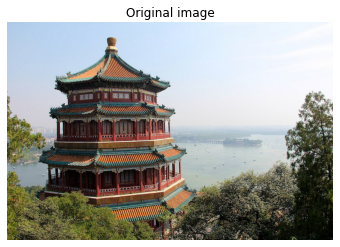

In [58]:
plt.imshow(img)
plt.axis('off')
plt.title('Original image')

In [61]:
encoded_image = tf.io.encode_jpeg(img) # Encoding the image data to bytes string

In [62]:
encoded_image

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01\xab\x02\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\

In [63]:
# Creating a protobuff `Example` from the string
image_record = Example(features = Features(feature = {'image' : Feature(bytes_list = BytesList(value = [encoded_image.numpy()]))}))

In [64]:
serialized_image = image_record.SerializeToString() # Serializing the Example which can be stored to TFRecord file when needed.

In [68]:
feature_description = {'image' : tf.io.VarLenFeature(tf.string)} # Desc dict

In [69]:
image_record = tf.io.parse_single_example(serialized_image, feature_description) # Parsing the bytes string

In [73]:
image_record['image'].values

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01\xab\x02\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x8

In [74]:
decode_image = tf.io.decode_jpeg(image_record['image'].values[0])

Text(0.5, 1.0, 'After encoding and decoding')

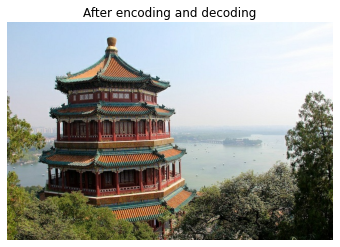

In [76]:
plt.imshow(decode_image)
plt.axis('off')
plt.title('After encoding and decoding')

### Tensors ans SparseTensors in TFRecord

In [77]:
t = tf.constant([[1., 2.], [3., 4.], [5., 6.]])
s = tf.io.serialize_tensor(t)

In [78]:
s

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@\x00\x00\xc0@'>

In [79]:
tf.io.parse_tensor(s, out_type = tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [3., 4.],
       [5., 6.]], dtype=float32)>

## Handling sequential data using `SequenceExample`

```proto
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
  Features context = 1;
  FeatureLists feature_lists = 2;
};
```

In [83]:
# Creating the context for SequenceExample
context = Features(feature = {'author_id' : Feature(int64_list = Int64List(value = [123])), 
                               'title' : Feature(bytes_list = BytesList(value = [b'A', b'Desert', b'Place', b'.'])), 
                               'pub_date' : Feature(int64_list = Int64List(value = [1623, 12, 25]))})

In [84]:
content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

In [85]:
def words_to_feature(words): # Func for converting content and comments to Features
    return Feature(bytes_list = BytesList(value = [word.encode('utf-8') for word in words]))

In [87]:
# Converting context and comment to features
content_features = [words_to_feature(sentence) for sentence in content]
comment_features = [words_to_feature(sentence) for sentence in comments]

In [88]:
# Creating the SequenceExample
sequence_example = SequenceExample(context = context, feature_lists = FeatureLists(feature_list = {'content' : FeatureList(feature = content_features), 
                                                                                                   'comment' : FeatureList(feature = comment_features)}))

In [89]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "Desert"
        value: "Place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comment"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
       

In [90]:
# Serializing the created sequence example
serialized_sequence_example = sequence_example.SerializeToString()

In [92]:
serialized_sequence_example

b"\nL\n\x12\n\tauthor_id\x12\x05\x1a\x03\n\x01{\n\x14\n\x08pub_date\x12\x08\x1a\x06\n\x04\xd7\x0c\x0c\x19\n \n\x05title\x12\x17\n\x15\n\x01A\n\x06Desert\n\x05Place\n\x01.\x12\xcf\x01\nj\n\x07content\x12_\n*\n(\n\x04When\n\x05shall\n\x02we\n\x05three\n\x04meet\n\x05again\n\x01?\n1\n/\n\x02In\n\x07thunder\n\x01,\n\tlightning\n\x01,\n\x02or\n\x02in\n\x04rain\n\x01?\na\n\x07comment\x12V\n&\n$\n\x04When\n\x03the\n\nhurlyburly\n\x02's\n\x04done\n\x01.\n,\n*\n\x04When\n\x03the\n\x06battle\n\x02's\n\x04lost\n\x03and\n\x03won\n\x01."

In [91]:
# Creating the desc for context
context_feature_desc = {'author_id' : tf.io.FixedLenFeature([], tf.int64, default_value = 0), 
                        'pub_date' : tf.io.FixedLenFeature([3], tf.int64, default_value = [0, 0, 0]), 'title' : tf.io.VarLenFeature(tf.string)}

In [94]:
# Creating the desc for sequence feature list
sequence_feature_desc = {'content' : tf.io.VarLenFeature(tf.string), 'comment' : tf.io.VarLenFeature(tf.string)}

In [95]:
# Parsing the serialized SequenceList
parsed_context, parsed_feature_list = tf.io.parse_single_sequence_example(serialized_sequence_example, context_features = context_feature_desc, 
                                                                          sequence_features = sequence_feature_desc)

In [96]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f5316f5d6d0>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25])>}

In [100]:
parsed_context['title'].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'Desert', b'Place', b'.'], dtype=object)>

In [102]:
parsed_feature_list

{'comment': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f5316f5d1f0>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7f5316f42640>}

In [105]:
# Converting the sparse feature list to Ragged tensor
print(tf.RaggedTensor.from_sparse(parsed_feature_list['comment']))

<tf.RaggedTensor [[b'When', b'the', b'hurlyburly', b"'s", b'done', b'.'], [b'When', b'the', b'battle', b"'s", b'lost', b'and', b'won', b'.']]>
